# WhatsApp Text Analysis
Messages and dataframes are not shown for privacy concerns.

In [322]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emoji
import collections
import operator
import seaborn as sns
import datetime
import pytz
import plotly.graph_objects as go
from nltk.stem import LancasterStemmer
plt.style.use('ggplot')
%matplotlib inline
#sns.set(rc={'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'})
#fig, ax = plt.subplots()

In [323]:
# Reading the whatsApp text file
file = open(r'./WhatsApp Chat with G1ers.txt',mode='r',encoding="utf8")
data = file.read()
file.close()
#data

In [324]:
# utility function for accepting the format of date:
def valid_date(datestring):
        try:
                mat=re.match('(\d{1,2})[/.-](\d{1,2})[/.-](\d{2,4})$', datestring)
                if mat is not None:
                        #datetime.datetime(*(map(int, mat.groups()[-1::-1])))
                        return True
        except ValueError:
                pass
        return False

In [325]:
# reading the text file and getting each individual messages and their details in the form of lists:
lines = []
with open('WhatsApp Chat with G1ers.txt',mode='r',encoding='utf8') as f:
    for line in f:
        if valid_date(line.split(',')[0]):
            lines.append(line.strip('\n'))
        else:
            lines[len(lines) - 1] += ' ' + line.strip('\n')
lines[2]

'10/26/19, 5:39 PM - Naman: EXCLUSIVE GROUP FOR G-1 RESIDERS'

In [326]:
del lines[0]

In [327]:
print(len(lines))

1976


In [328]:
# just a hack for automating the format of year in the date which goes as a parameter in the strptime function:
temp=lines[0]
temp=temp.split(', ')[0]
temp=temp[::-1]
cnt=0
for i in temp:
    cnt+=1
    if(i=='/'):
        break
cnt-=1
if(cnt==2):
    yr='y'
else:
    yr='Y'

In [329]:
def valid_user(lsts):
    if len(lsts) == 5 and not 'changed' in lsts[-1] and not 'left' in lsts[-1] and not 'added' in lsts[-1] and not 'created' in lsts[-1] and not 'removed' in lsts[-1] and not 'admin' in lsts[-1]:
        return True
    elif '+91' in lsts[-1] and len(lsts) <= 3:
        return True
    return False

In [330]:
# defining the regex pattern for grabbing information from the list 'lines' we created:
pattern2 = re.compile('(\d?\d+:\d\d)+\s+(pm|am|PM|AM)+\s+-\s+([a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?[a-zA-Z0-9]+\s?):\s+')

In [331]:
# extracting all necessary details of a specific message for creating a well structured dataframe:
dates=[]
datetimes=[]
times=[]
msgs=[]
messengers=[]
# format of date='%d/%m/%Y' or '%m/%d/%Y' or '%d/%m/%y' or ''%m/%d/%Y'
# only %m/%d or %d/%m needs to be mentioned.
for each in lines:
    lsts=pattern2.split(each)
    #print(lsts)
    if(not valid_user(lsts)):
        continue
    x=lsts[0].split(', ')[0]
    dates.append(x)
    times.append(lsts[1]+' '+lsts[2]) 
    pat=x+', '+lsts[1]+' '+lsts[2]
    datetimes.append(datetime.datetime.strptime(pat, '%m/%d/%'+yr+', %I:%M %p')) # format should be mentioned, either %m/%d or %d/%m.
    msgs.append(lsts[4])
    messengers.append(lsts[3])

In [332]:
names=[y for y in np.unique(messengers)]  # obtaining the names of the participants as list.
names

['Amit 2', 'Anubhav', 'Naman', 'Viraj Che']

In [333]:
# Move your name at the end of the list:
my_name='naman'
for i in range(len(names)):
    if(names[i].lower()==my_name.lower()):
        idx=i
        break
names.sort(key=names[idx].__eq__) 
names

['Amit 2', 'Anubhav', 'Viraj Che', 'Naman']

In [334]:
# counts of messages by all participants of the chat in an ordered dictionary (having the keys(or names) 
# in same order as that in the list).
count_messages=collections.OrderedDict()
for i in names:
    for each in messengers:
        if(i.lower()==each.lower()):
            if each in count_messages.keys():
                count_messages[i]+=1
            else:
                count_messages[i]=1
count_messages

OrderedDict([('Amit 2', 351),
             ('Anubhav', 305),
             ('Viraj Che', 550),
             ('Naman', 759)])

In [335]:
# total messages of the chat: 
total=0
for each in count_messages:
    total=total+count_messages[each]
print('Total messages exchanged: '+str(total))

Total messages exchanged: 1965


In [336]:
# defining our dataframe:
data_df=pd.DataFrame(columns=['datetime','time','name','messages','date','day','month','year','count'])
data_df

,datetime,time,name,messages,date,day,month,year,count


In [337]:
# filling the dataframe with values:
data_df['datetime']=datetimes
data_df['time']=times
data_df['name']=messengers
data_df['messages']=msgs
data_df['date'] = data_df['datetime'].apply(lambda x: x.date())
data_df['day'] = data_df['datetime'].dt.strftime('%a')
data_df['month'] = data_df['datetime'].dt.strftime('%b')
data_df['year'] = data_df['datetime'].dt.year
data_df['count'] = 1

In [338]:
data_df.head(1)

,datetime,time,name,messages,date,day,month,year,count
0,2019-10-26 17:39:00,5:39 PM,Naman,EXCLUSIVE GROUP FOR G-1 RESIDERS,2019-10-26,Sat,Oct,2019,1


In [339]:
msgs[0] # list of all messages

'EXCLUSIVE GROUP FOR G-1 RESIDERS'

In [340]:
# Separate the messages of every participant and append them one after another:
sep_msgs=[]
for each in count_messages.keys():
    for msg in range(len(msgs)):
        if each == messengers[msg]:
            sep_msgs.append(msgs[msg])   #obtaining the message corresponding to the participant who sent it.b
print(len(sep_msgs))   
sep_msgs[11:15]

1965


['Ok', 'Thik h', 'Bhai', 'Tum btao']

In [341]:
# Creating another dataframe with columns as names of the participants and the rows containing there messages
who_sent_what = []
prev = 0
for each in count_messages.keys():
    num = count_messages[each]
    
    nex = num+prev
    messages = sep_msgs[prev:nex]
    who_sent_what.append(messages)
    prev = nex
who_sent_what
msg_df=pd.DataFrame(who_sent_what)
msg_df = msg_df.transpose()
msg_df.columns = [y for y in names]

In [342]:
#msg_df.head(10)

In [343]:
# getting the information of message deletions:
xlast_del=0;
for i in msg_df.iloc[:,-1]:
    if(i=='You deleted this message'):
        xlast_del+=1
print('Messages deleted by '+'{}'.format(names[-1]) +': '+str(xlast_del))
xi_del=0
for i in range(len(names)-1):
    xi_del=0
    for j in msg_df.iloc[:,i]:
        if(j=='This message was deleted'):
            xi_del+=1
    print('Messages deleted by '+'{}'.format(names[i]) +': '+str(xi_del)) 

Messages deleted by Naman: 0
Messages deleted by Amit 2: 0
Messages deleted by Anubhav: 1
Messages deleted by Viraj Che: 10


In [344]:
# getting information of media exahnges:
xlast_media=0;
for i in msg_df.iloc[:,-1]:
    if(i=='<Media omitted>'):
        xlast_media+=1
print('Media files sent by '+'{}'.format(names[-1]) +': '+str(xlast_media))
xi_media,xi_tot=0,0
for i in range(len(names)-1):
    xi_media=0
    for j in msg_df.iloc[:,i]:
        if(j=='<Media omitted>'):
            xi_media+=1
    xi_tot+=xi_media
    print('Media files sent by '+'{}'.format(names[i])+': '+str(xi_media))
print('Total media exhachanged: '+str(xlast_media+xi_tot))

Media files sent by Naman: 46
Media files sent by Amit 2: 6
Media files sent by Anubhav: 47
Media files sent by Viraj Che: 69
Total media exhachanged: 168


Text(0.5, 1.0, 'Total Media Sent')

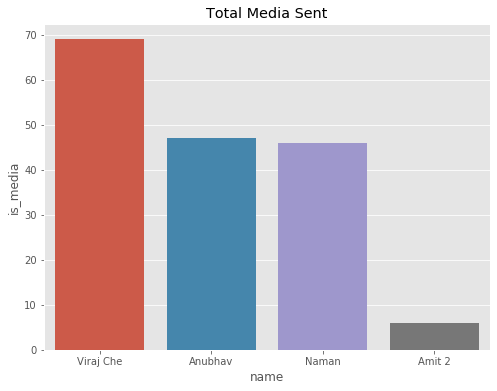

In [345]:
# Barplot of total media count
plt.figure(figsize = (8, 6))
data_df['is_media'] = data_df['messages'].apply(lambda x: 1 if '<Media omitted>' in x else 0)
data_df.groupby('name').sum().reset_index().sort_values(by = 'is_media', ascending = False)[['name', 'is_media']]
total_media_count = data_df.groupby('name').sum().reset_index().sort_values(by = 'is_media', ascending = False)[['name', 'is_media']]
sns.barplot(x = 'name', y = 'is_media', data = total_media_count)
plt.title('Total Media Sent')

In [346]:
# defining the helper function to extract emojis:
def extract_emojis(columnname):
    emojis=[]
    for string in msg_df[columnname]:
        my_str = str(string)
        for each in my_str:
            if each in emoji.UNICODE_EMOJI:
                emojis.append(each)
    return emojis

In [347]:
# Getting the emojis sent by each participant and their corresponding count
emoji_dict={}
top5_emj=collections.OrderedDict()
tot_emj=collections.OrderedDict()
#emoji_df=pd.DataFrame()
emoji_all=pd.DataFrame(columns=['name','emojis_used','total_emojis','distinct_emojis_sent'])
emoji_all['name']=names
t=0
d={}
unique_emojis=set()

for keys in count_messages.keys():
    
    print()
    print('Top 5 emojis sent by: '+keys)
    
    emoji_dict[keys] = extract_emojis(keys)
    emoji_df=pd.DataFrame(emoji_dict[keys])
    d={}
    x=emoji_df[0].value_counts()
    unique_emojis.update(x.index)
    for i in x.index:
        d[i]=x[i]
    emoji_all['emojis_used'][t]=d                      # details of total emojis by each participant
    emoji_all['distinct_emojis_sent'][t]=len(x.index)  # how many different emojis are sent by each participant
    t+=1
    
    tot_emj[keys]=len(emoji_df)
    top5_emj[keys]=emoji_df[0].value_counts()[:5]
    print(emoji_df[0].value_counts()[:5])


Top 5 emojis sent by: Amit 2
😅    77
😁    54
🤣    48
😂    38
🙄    18
Name: 0, dtype: int64

Top 5 emojis sent by: Anubhav
🤣    91
😂    58
😉    23
😭    16
😅    14
Name: 0, dtype: int64

Top 5 emojis sent by: Viraj Che
😂    89
🤣    84
😅    68
😄    31
🤩    16
Name: 0, dtype: int64

Top 5 emojis sent by: Naman
🤣    112
😂    101
😁     81
😅     45
👍     21
Name: 0, dtype: int64


In [348]:
# Getting the frequency of each distinct emoji in the chat:
freq_emojis=collections.OrderedDict()
for i in unique_emojis:
    for dct in emoji_all['emojis_used']:
        for each,val in dct.items():
            if i==each:
                if i in freq_emojis.keys():
                    freq_emojis[i]+=val
                else:
                    freq_emojis[i]=val

In [349]:
# sorting the freq_emojis dictionary by values: 
sorted_x = sorted(freq_emojis.items(), key=operator.itemgetter(1))
sorted_freq_emojis=collections.OrderedDict(sorted_x)

# most frequent emoji exchanged in the chat:
list(sorted_freq_emojis.keys())[-1]

'🤣'

In [350]:
# doing the above thing other way round:
list(freq_emojis.keys())[list(freq_emojis.values()).index(max(sorted(freq_emojis.values())))]

'🤣'

In [351]:
emoji_all

,name,emojis_used,total_emojis,distinct_emojis_sent
0,Amit 2,"{'😅': 77, '😁': 54, '🤣': 48, '😂': 38, '🙄': 18, ...",NaN,29
1,Anubhav,"{'🤣': 91, '😂': 58, '😉': 23, '😭': 16, '😅': 14, ...",NaN,15
2,Viraj Che,"{'😂': 89, '🤣': 84, '😅': 68, '😄': 31, '🤩': 16, ...",NaN,40
3,Naman,"{'🤣': 112, '😂': 101, '😁': 81, '😅': 45, '👍': 21...",NaN,40


In [352]:
# overall different types of emojis sent by the pariticipant as a whole for this chat:
len(unique_emojis)

80

In [353]:
# total emojis by every paricipant and filling the 'total_emojis' column of the emoji_all dataframe:
to=0
t=0
for i in tot_emj:
    to+=tot_emj[i]
    emoji_all['total_emojis'][t]=tot_emj[i]
    t+=1
    print('Total emojis sent by '+'{}'.format(i)+': '+str(tot_emj[i]))
print('Total emojis exchanged: '+str(to))

Total emojis sent by Amit 2: 362
Total emojis sent by Anubhav: 235
Total emojis sent by Viraj Che: 416
Total emojis sent by Naman: 434
Total emojis exchanged: 1447


In [354]:
emoji_all

,name,emojis_used,total_emojis,distinct_emojis_sent
0,Amit 2,"{'😅': 77, '😁': 54, '🤣': 48, '😂': 38, '🙄': 18, ...",362,29
1,Anubhav,"{'🤣': 91, '😂': 58, '😉': 23, '😭': 16, '😅': 14, ...",235,15
2,Viraj Che,"{'😂': 89, '🤣': 84, '😅': 68, '😄': 31, '🤩': 16, ...",416,40
3,Naman,"{'🤣': 112, '😂': 101, '😁': 81, '😅': 45, '👍': 21...",434,40


Text(0.5, 1.0, 'Distinct Emojis Used')

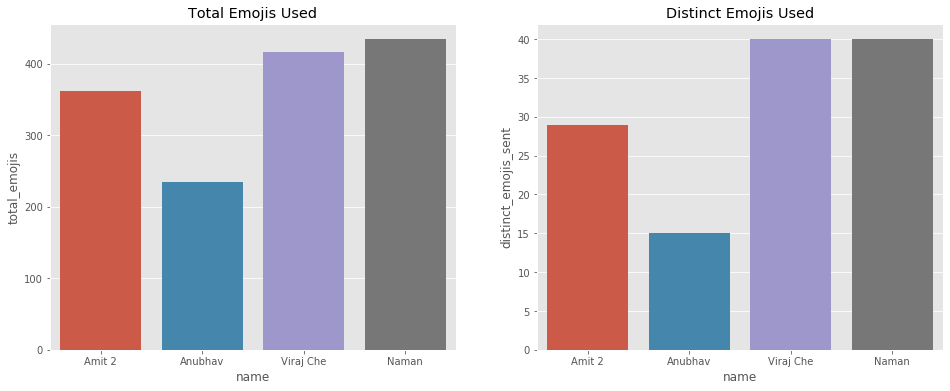

In [355]:
fig, axs = plt.subplots(ncols = 2, figsize = (16, 6))

# visualizing the total messages by each participant:
sns.barplot(x = 'name', y = 'total_emojis', data = emoji_all,ax=axs[0])
axs[0].set_title('Total Emojis Used')

# visualizing distinct emojis sent by each participant;
sns.barplot(x='name',y='distinct_emojis_sent',data=emoji_all,ax=axs[1])
axs[1].set_title('Distinct Emojis Used')

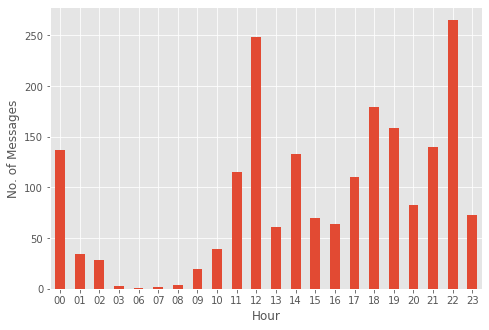

In [356]:
# plotting a graph showing pattern of number of messages distributed over different hours of the day: 

# for this task, below code seems to be a bit complicated, isn't it? No problem, we'll do it in an easier way a bit later. This was just an experiment
# to do it from a little scratch.

hour_pattern = '(\d+):\d+\s+(am|pm|AM|PM)+\s+-\s+\w+\s?\w+?\s?\w+\s?\w+:\s'
hours = re.findall(hour_pattern,data)
hrs=[]
for i in hours:   # converting 'hh:mm PM/AM/pm/am' format in 24 hours time format 
    if(i[1]=='pm' or i[1]=='PM'):
        if(int(i[0])>=1 and int(i[0])<=11):
            hrs.append(str(int(i[0])+12))
        else:
            hrs.append(i[0])
    else:
        if(int(i[0])>=12):
            hrs.append('00')
        else:
            if(int(i[0])>=1 and int(i[0])<=9):
                hrs.append('0'+i[0])
            else:
                hrs.append(i[0])  
time = pd.DataFrame({'hours':hrs})
busy_hours = time['hours'].value_counts()
busy_hours.sort_index(inplace=True)
plt.axes([1,1,1,0.98])
plt.grid(True)
busy_hours.plot.bar()
plt.xlabel('Hour')
plt.ylabel('No. of Messages')
plt.xticks(rotation=0)
plt.show()
%matplotlib inline

Text(0.5, 1.0, 'Average Message Lengths')

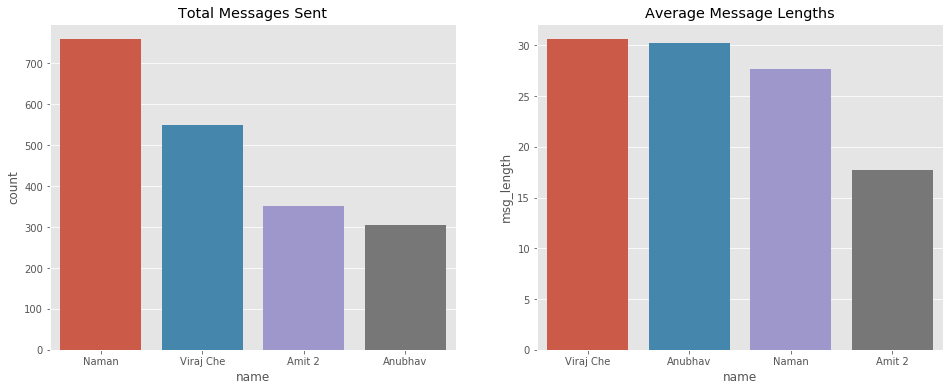

In [357]:
# Countplot of total messages sent
fig, axs = plt.subplots(ncols = 2, figsize = (16, 6))
sns.countplot(x = 'name', data = data_df, order = data_df['name'].value_counts().index, ax=axs[0] )
axs[0].set_title('Total Messages Sent')

# Barplot of average message lengths
data_df['msg_length'] = data_df['messages'].apply(lambda x: len(x))
avg_msg_lengths =data_df.groupby('name').mean().reset_index().sort_values(by = 'msg_length', ascending = False)
sns.barplot(x = 'name', y = 'msg_length', data = avg_msg_lengths, ax = axs[1])
axs[1].set_title('Average Message Lengths')

Text(0.5, 1.0, 'Total messages sent grouped by month')

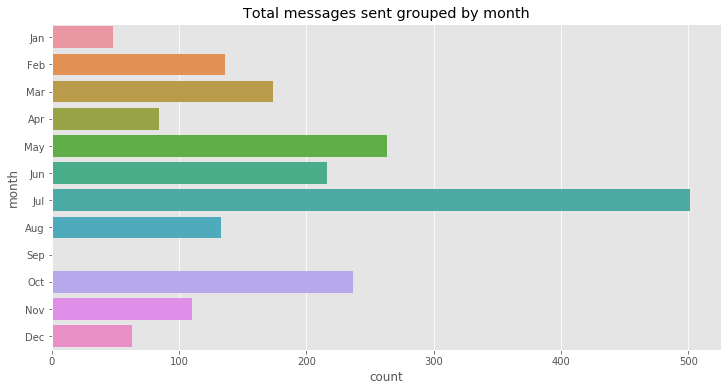

In [358]:
# Total messages sent spanning over a month:
fig, ax = plt.subplots(ncols = 1, figsize = (12, 6))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
grouped_by_month = data_df.groupby('month').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(x = 'count', y = 'month', data = grouped_by_month, order = months, ax = ax)
ax.set_title('Total messages sent grouped by month')

Text(0.5, 1.0, 'Most Active Hours')

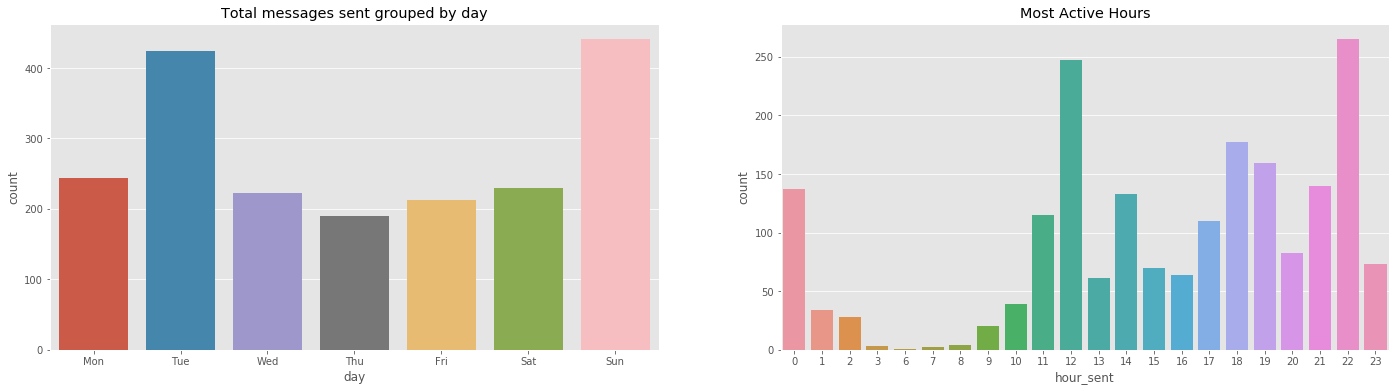

In [359]:
# Total messages spanning over a day: 
fig, axs = plt.subplots(ncols = 2, figsize = (24, 6))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
grouped_by_day = data_df.groupby('day').sum().reset_index()[['day', 'count']]
sns.barplot(y = 'count', x = 'day', data = grouped_by_day, order = days, ax = axs[0])
axs[0].set_title('Total messages sent grouped by day')

# here's the simpler way (the thing that seemed to be bit complicated):
# most active hours of talk:
data_df['hour_sent'] = data_df['datetime'].apply(lambda x: x.hour)
grouped_by_time = data_df.groupby('hour_sent').sum().reset_index().sort_values(by = 'count', ascending = False)
sns.barplot(y = 'count', x = 'hour_sent', data = grouped_by_time, ax = axs[1])
axs[1].set_title('Most Active Hours')

Text(0.5, 1.0, 'Most Active Days')

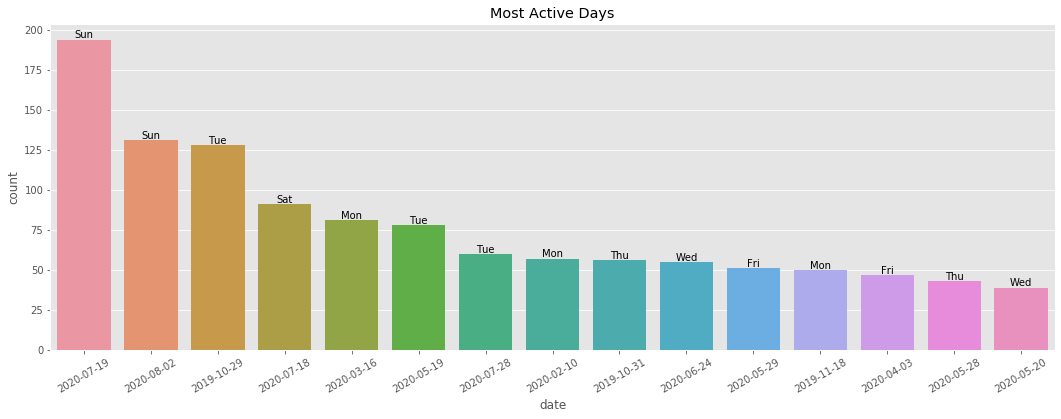

In [360]:
plt.figure(figsize = (18, 6))

grouped_by_date = data_df.groupby('date').sum().reset_index().sort_values(by = 'count', ascending = False).head(15)
grouped_by_date['day'] = grouped_by_date['date'].apply(lambda x: x.strftime('%a'))
ax = sns.barplot(y = 'count', x = 'date', data = grouped_by_date)

for bar, label in zip(ax.patches, grouped_by_date['day']):
    x = bar.get_x()
    width = bar.get_width()
    height = bar.get_height()
    ax.text(x + width/2., height + 1, label, ha="center") 

ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.title('Most Active Days')

In [363]:
# final structure of data_df
data_df.head(1)

,datetime,time,name,messages,date,day,month,year,count,is_media,msg_length,hour_sent
0,2019-10-26 17:39:00,5:39 PM,Naman,EXCLUSIVE GROUP FOR G-1 RESIDERS,2019-10-26,Sat,Oct,2019,1,0,32,17
